<a href="https://colab.research.google.com/github/imitusov/kaggle-lenta-news/blob/master/lenta_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports 
---

In [0]:
# Install CatBoost and others
!pip install -q catboost
!pip install -q bayesian-optimization
!pip install -q pymorphy2
!pip install -U -q pymorphy2-dicts-ru
!pip uninstall pymystem3 # (https://github.com/nlpub/pymystem3/issues/28)
!pip install -q pymystem3==0.1.10

%load_ext autoreload
%matplotlib inline
%xmode Plain
%autoreload 2

# Warnings
import warnings
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# f1_score warning that there is no class in y_pred that exist in y_test
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning) 

# Basic imports
from IPython.display import clear_output
import os 
import shutil
import random
import gc
import datetime
import re
import pandas as pd
import numpy as np
from typing import List
from google.colab import drive, files

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import pymorphy2 as pm2
from pymystem3 import Mystem
from collections import defaultdict
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('punkt')
nltk.download('words')

# Sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import NuSVC, LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder, PowerTransformer, \
StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Boosting libs
import catboost as ctb
import lightgbm as lgb

# Local root
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/Colab Notebooks/lenta-news/' 
os.chdir(root_path)

# Seed
seed_value = 31
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# Plots
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns

# Set matplotlob params
plt.style.use('seaborn-white')
plt.rc('figure', figsize=(12, 8))
plt.rc('lines', lw=2, c='g')
plt.rc('image', cmap='plasma')
plt.rc('axes', facecolor=(0, 0, 0, 0), titlesize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

clear_output()

## Download data

In [0]:
# Set up 'lenta-news' dir for files 
os.mkdir('/content/drive/My Drive/Colab Notebooks/lenta-news/') 
root_path = '/content/drive/My Drive/Colab Notebooks/lenta-news/'
os.chdir(root_path)

# Clone git, run news parser
!git clone https://github.com/yutkin/Lenta.Ru-News-Dataset.git

# Check downloaded files
os.chdir(root_path + os.listdir(root_path)[0])

# Move files to a newly created dir
for files in os.listdir():
    shutil.move(files, root_path)
os.chdir(root_path)

# Remove an extra dir
os.rmdir('Lenta.Ru-News-Dataset')

# Install dependecies
!pip install -q -r requirements.txt

# Unfortunally python 3.7 is required. 3.6 is installed on Colab
#!python download_lenta.py - doesn't work

# Manual download
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

# Unpack the data
!gzip -d lenta-ru-news.csv.gz

clear_output()

## Basic feature extraction

Lets upload data and make brief feature extraction from URL column.

In [0]:
# Upload data
df = pd.read_csv(f'{root_path}lenta-ru-news.csv')

# Extract URL data
df_url = df['url'].str.split('/', expand=True).drop([1, 8], axis=1)
df_url.columns = ['protocol', 'site', 'section', 'year', 'month', 'day', 'extension']
df_url[['year', 'month', 'day']] = df_url[['year', 'month', 'day']].astype(int)

# Concat extracted info and original data
df = pd.concat([df, df_url], axis=1)
df.drop(['url'], axis=1, inplace=True)
del df_url

# No unique values - drop columns from set
print(df['protocol'].value_counts().head())
print(df['site'].value_counts().head())
df = df.drop(['protocol', 'site'], axis=1)

https:    739351
Name: protocol, dtype: int64
lenta.ru    739351
Name: site, dtype: int64


In [0]:
# A minor issue - there is an extra space in 'Культпросвет ' word
print(sum(df['topic'] == 'Культпросвет '))

# Remove an extra space
df.loc[df[df['topic'] == 'Культпросвет '].index, 'topic'] = 'Культпросвет'

340


# Brief EDA
---


First we plot and check target variable distribution. 

Conclusion:
- Set is highly unbalanced
- There are several topics with nearly 0 appereance in set

In [0]:
def plot_variable_count(df, variable):
    """ Plot variable category counts"""

    df[variable].value_counts(ascending=True).plot(kind='barh', width=0.8, colormap='plasma')
    plt.title(f'{variable} variable distribution', size=16)

plot_variable_count(df, 'topic')

We've found out several nearly zero count topics. Let's find out what share of the dataframe they are account for?

The main question is: does any kind of exchange exist between dropping that topics and still mantain a good model performance. The main issue is that we may remove rare topic and have 100% error on them. Otherwise we may include them in the training set and some part of bigger topics may be missclassified as rare categories. 

Is there a tradeoff between the aforementoined statements?

In [0]:
rare_topics = ['Культпросвет', 'Легпром', 'Библиотека', 'Оружие', 'ЧМ-2014', 'Сочи', 'МедНовости'] 
rare_topic_share = np.mean(df['topic'].isin(rare_topics)) * 100

print(f'Only {rare_topic_share:.3f}% of data is account for rare topics')

Only 0.071% of data is account for rare topics


Lets plot the overall amount of topics that have been published for each year

Conclusions:
- There is 1914. Should it be considered as 2014?
- Rapid growth till 2009, smooth decrease up to 2014, rapid growth at 2016 and qiuck drop at 2018 to the 2013-2015 years results  

In [0]:
def plot_variable_count_year(df, variable):
    """ Total amount of publication per year"""

    df.groupby('year').count()[variable].plot(kind='bar', width=0.8, colormap='plasma')
    plt.title(f'Total amount of {variable} distributed in time', size=16)

plot_variable_count_year(df, 'topic')

All 1914's articles are in fact have been published in 2014 (checked!)

In [0]:
# Fix year of the articles
df.loc[df[df['year'] == 1914].index, 'year'] = 2014

# Sort instances by date
df.sort_values(['year', 'month', 'day'], ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)

Quantity of topics is increasing in time, lets check and compare normalized distribution of topics counts for each year

Conclusion:
- Topic categories become more equally distributed as time goes

In [0]:
def plot_top_variable_structure(df, variable):
    """Plot top-11 normalized categories of a variable for each year""" 

    # identify rare categories for variable
    rare_categories = df[variable].value_counts()[11:].index 
    
    # Create appropriate structure for graph
    df_pivot = df.groupby(['year', variable]).size().reset_index().\
    pivot(columns=variable, index='year', values=0).\
    sort_values(2018, axis=1, ascending=False).fillna(0)
    
    # Sum rare categories into one big
    df_pivot['Прочие'] = df_pivot.loc[:, rare_categories].sum(axis=1, skipna=True)
    df_pivot = df_pivot.drop(rare_categories, axis=1)

    # Normalize the data
    df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    
    # Plot and add a legend
    df_pivot.plot(kind='bar', stacked=True, width=1, colormap='plasma')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.title(f'Structurial shifts of {variable} in time', size=16)

plot_top_variable_structure(df, 'topic')

Check missing values and remove instances that either have no topic or text values

In [0]:
def plot_nans(df):
    """Plot columns with nans"""
    
    nan_mask = df.isna().sum() > 0
    df.loc[:, nan_mask].isna().sum().sort_values().plot(kind='barh', width=0.8, colormap='plasma')

plot_nans(df)

In [0]:
# Drop texts with NaNs in topic
topic_drop_index = df.loc[df['topic'].isna().values, :].index
df.drop(topic_drop_index, axis=0, inplace=True)

# Drop texts without text
text_drop_index = df.loc[df['text'].isna().values, :].index
df.drop(text_drop_index, axis=0, inplace=True)
del topic_drop_index, text_drop_index
gc.collect()

print(f'There are {df.isna().sum().sum()} missing values in set')

There are 26314 missing values in set


Lets check when each category appeared in the set

Conclusion:
- New topics began to appear in 2014-2015 years
- Some of new topics have been dedicated to temporal events like Olympic games

In [0]:
def plot_topic_appearence(df, variable):
    """
    Plot the first and the last year appearence of the topic in the dataset.
    Each horizontal line indicated unique topic.
    Start of the line - first and end of the line - last apperiance in set
    """
    
    # find unique topic names
    set_variable_id = set(df[f'{variable}'])
    df_variable_id = []

    # find first and last appearance for each topic
    for i in set_variable_id:
        top = df[df[f'{variable}'] == i].index[0]
        top = df.loc[top, 'year']
        bottom = df[df[f'{variable}'] == i].index[-1]
        bottom = df.loc[bottom, 'year']
        df_variable_id.append(dict(Task=f'{i}', Start=top, Finish=bottom))
    
    # sort values, plot graph
    df_variable_id = sorted(df_variable_id, key=lambda x: (x['Start'], x['Finish'])) 
    fig = ff.create_gantt(df_variable_id, colors=['#d62728'], title='Topic distribution',
                          show_hover_fill=False, height=400, bar_width=1, width=600)
    fig.show()

plot_topic_appearence(df, 'topic')

## Metrics
---
- **Accuracy** isn't a good idea since our set is **unbalanced**, moreover we should consider **downsampling/oversampling** approaches

- As a metric we would choose **multiclass log-loss** as it may evaluate model confidence in a certain target class. Also multiclass log-loss is used on a data science competitions. F1-score or MCC metrics is also may be considered.

- Also it's reasonable to check a **multiclass confusion matrix** as it may reveal whether the model is being wrong on a concrete subset of training data

In [0]:
from sklearn.metrics import log_loss, f1_score, confusion_matrix, multilabel_confusion_matrix

# Create losses for cross-validation scores
f1score = make_scorer(f1_score, greater_is_better=True, average='weighted')
logloss = make_scorer(log_loss, greater_is_better=True, needs_proba=True)

# Cross-validation and metrics
---

## Time frame

Assumptions:
- Time is not important (we won't do TimeSeries splits for validation). As a result we won't keep that columns, otherwise model would see imformation from the future (if we shuffle). 

- Furthemore, there are a following heuristics: 1) there are years with biased proportion for several categories f.e. economic, business; 2) most part of label appeared in recent years; 3) time feature would lead to overfit for each years' target proportion but it would poorly generalize because in fact we don't know current and future trends; 4) some part of the topics wouldn't appear in future

- From EDA we find out that most part of labels appeared in recent years 2015-2018 - we squeeze training set to 2015-2018 and dropped other years

- In that case we would lose 'Сочи' and 'ЧМ-2014'

Question:
- There are 3 seldom topic categoires and 4 appears even less - what if we just drop them?

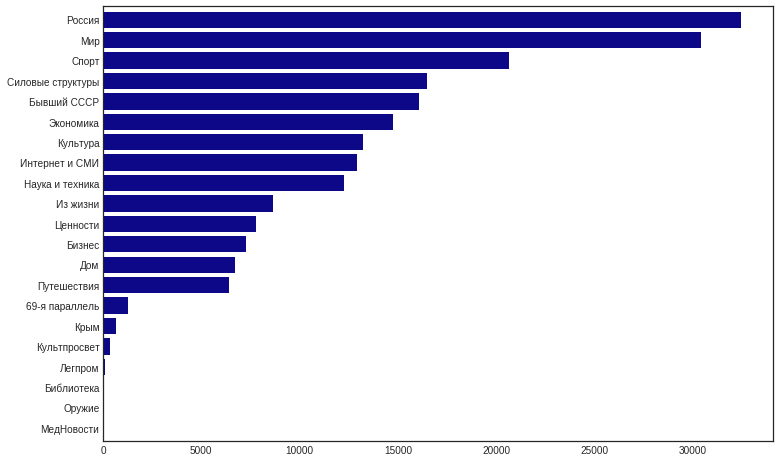

In [0]:
df[df['year'] >= 2015]['topic'].value_counts().sort_values().plot(kind='barh', width=0.8, colormap='plasma')

Assumptions:
- Following the business purpose of the model, if FN (false negatives) aren't important we may consider to drop rare target cats
- The main issue is that we may remove rare topic and have 100% error on them. Otherwise we may include them in the training set and some part of bigger topics may be missclassified as rare categories. 

In [0]:
# Percent of rare topic categories.
rare_topics_1 = ['Легпром', 'Библиотека', 'Оружие', 'МедНовости', 'Сочи', 'ЧМ-2014'] 
rare_topics_2 = ['Культпросвет', 'Легпром', 'Библиотека', 'Оружие', 'МедНовости', 'Крым', '69-я параллель'] 
ratio_1 = np.mean(df[df['year'] >= 2015]['topic'].isin(rare_topics_1)) * 100
ratio_2 = np.mean(df[df['year'] >= 2015]['topic'].isin(rare_topics_2)) * 100
print(f'{ratio_1:0.3f}% of df is for very rare topics')
print(f'{ratio_2:0.3f}% of df is for very rare and seldom topics')

0.059% of df is for very rare topics
1.150% of df is for very rare and seldom topics


Select only 2015 - ... years

In [0]:
# Older texts may not be considered as relevant but we may validate our clf on it
y_holdout = df[df['year'] < 2015]['topic']
X_holdout = df[df['year'] < 2015].drop(['topic'], axis=1)

y = df[df['year'] >= 2015]['topic']
X = df[df['year'] >= 2015].drop(['topic'], axis=1)
cols = X.columns

del df
gc.collect()

0

In [0]:
# Drop time-featured columns as we will shuffle data
X.drop(['year', 'month', 'day'], axis=1, inplace=True)

# Find rare topics
topics_to_drop = y.value_counts()[y.value_counts() < 10].index
index_to_drop = y[y.isin(topics_to_drop)].index

# Drop indecies with rare topics
X.drop(index_to_drop, axis=0, inplace=True)
y.drop(index_to_drop, axis=0, inplace=True)

# Same manipulations for X_holdout
X_holdout.drop(['year', 'month', 'day'], axis=1, inplace=True)
index_to_drop = y_holdout[y_holdout.isin(topics_to_drop)].index

# Drop indecies with rare topics for holdout set
X_holdout.drop(index_to_drop, axis=0, inplace=True)
y_holdout.drop(index_to_drop, axis=0, inplace=True)

## Cross-validation

Assumptions:
- Create a holdout set (X_test) to check generalization error on relevant set (25%)
- We also have (X_holdout) - check generalization for old set 

Cross-validation schemes:
- (basic) 1 stratified validation set
- (additional) Use 5-fold cross-validation with shuffle (as we don't assume this task to be a time-specific)

In [0]:
CROSSVAL = 'basic'

# Create a stratified test set for a generalization error score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=31, stratify=y)

# Reset index
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Choose cv scheme
if CROSSVAL == 'basic':
    cv = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=31)
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=31)

# Preprocessing
---

## Drop features

In [0]:
# Drop unused features
X_train.drop(['tags', 'section', 'extension'], axis=1, inplace=True)
X_test.drop(['tags', 'section', 'extension'], axis=1, inplace=True)
X_holdout.drop(['tags', 'section', 'extension'], axis=1, inplace=True)

## Clean text

In [0]:
def string_to_tokens(text: str) -> List[str]:
    """ 
    Transform sentence to list with tokens. Remove punctuation, lower letters,
    remove stop-words and digits, limmatization

    :param text: plain text instance
    :return: clean list with tokens 
    """

    replacer = str.maketrans('', '', string.punctuation + '«»')
    stop_words = stopwords.words('russian')
    mystem = Mystem()

    regex_pattern = '[a-zA-Z0-9]'

    # Remove punctuatuion, english words, digits, make letters lower, tokenize
    token_string = word_tokenize(re.sub(regex_pattern, '',
                                        text.translate(replacer).lower()))
    
    # Perform all filters and lemmatization in one loop
    token_string = [mystem.lemmatize(word)[0] # lemmatization
                    for word in token_string # loop through tokens
                    if word not in stop_words # drop stopwords
                    and word.isalpha() # drop digits
                    and len(word) > 2]  # drop short words
    return token_string

def frequency_dict(column: str) -> dict:
    """
    Create a frequency dict of a corpus
    :param column: df column name with tokens
    :return: dict
    """

    frequency = defaultdict(int)
    for sentence in X_train.loc[:, column]:
        for word in sentence:
            frequency[word] += 1
    return frequency

def remove_rare_words(text: List[str], frequency: dict) -> List[str]:
    """
    Remove rare words according to passed frequency dictionary (frequency == 1)
    :param text: list of tokens per instance
    :param frequency: frequency dictionary for relevant column
    """ 

    text = [word for word in text if frequency[word] != 1]
    return text

# Preprocessing that doesn't work
---
- Calculated text statistics about word, tag, char and etc. counts make score even 0.2 worse

## Basic steps
---
Assumptions:
- Applying all transformation for **title** and **text** blocks separatly

TO-DO:
- Apply translation to **tags** and **extension** features (via googletrans 2.4.0)
- More **per sentence** statistics
- **Direct speech** statistics analysis (statistics differences with main text of the article)

Questions:
- Rare target topics - what to do?
- Are **tags** and **extension** columns important?
- Is **time** feature important?
- Are there any **rolling** statistics for texts? 
- Are there more efficient approaches rather than `.apply(lambda x: x)`?
- How to opitmize calculation of a **ncommon_n** feature statistics?

In [0]:
# Install libraries and dependecies
!pip install -q pymorphy2
!pip install -U -q pymorphy2-dicts-ru
!pip uninstall pymystem3 # Current version doesn't work in colab (https://github.com/nlpub/pymystem3/issues/28)
!pip install -q pymystem3==0.1.10
clear_output()

In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import pymorphy2 as pm2
from pymystem3 import Mystem
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('punkt')

clear_output()

In [0]:
# Create a small set from df to check all transformation, then apply to the whole df
df_small, _, y_small, _ = train_test_split(X, y, train_size=0.045, stratify=y, random_state=31)
y_small = y.loc[df_small.index]
df_small.reset_index(drop=True, inplace=True)
y_small.reset_index(drop=True, inplace=True)

## Feature engineering before cleaning
PLAN:
1. (done) Total number of words in document 
2. (done) Total number of punctuation marks in document 
3. (done) Total number of upper count words 
4. (done) Total number of title words 
5. Amount for Foreign words (via Polyglow)
6. (done) Vocablurary diversity 
7. (done) Per sentence statistics 

(time) (3000 samples - 31.5 sec.)

In [0]:
def text_feature_statistic_raw(df, text_column):
    """Calculate word/sentence statistics on raw df text set"""

    # Main statistics per text
    stop_words = stopwords.words('russian')
    df_statistics = pd.DataFrame()
    df_statistics[f'word_count_{text_column}'] = df[text_column].apply(lambda x: len([word for word in word_tokenize(x) if word not in string.punctuation]))
    df_statistics[f'punc_count_{text_column}'] = df[text_column].apply(lambda x: len(''.join(punc for punc in x if punc in string.punctuation)))
    df_statistics[f'title_word_count_{text_column}'] = df[text_column].apply(lambda x: len([word for word in word_tokenize(x) if word.istitle()]))
    df_statistics[f'upper_word_count_{text_column}'] = df[text_column].apply(lambda x: len([word for word in word_tokenize(x) if word.isupper()]))
    df_statistics[f'is_digit_{text_column}'] = df[text_column].apply(lambda x: len([word for word in word_tokenize(x) if word.isdigit()]))
    df_statistics[f'stop_words_count_{text_column}'] = df[text_column].apply(lambda x: len([word for word in word_tokenize(x) if word in stop_words]))
    df_statistics[f'stop_words_share_{text_column}'] = df_statistics[f'stop_words_count_{text_column}'] / (df_statistics[f'word_count_{text_column}'] + 1)
    
    # Main statistics per sentences
    df_statistics[f'sentence_count_{text_column}'] = df[text_column].apply(lambda x: len(sent_tokenize(x)))
    df_statistics[f'sentence_density_{text_column}'] = df_statistics[f'word_count_{text_column}'] / df_statistics[f'sentence_count_{text_column}']
    
    return df_statistics

new_features = text_feature_statistic_raw(df_small, 'text')
df_small = pd.concat([df_small, new_features], axis=1)

new_features = text_feature_statistic_raw(df_small, 'title')
df_small = pd.concat([df_small, new_features], axis=1)

# df_small.head(2)

## Text cleaning
---
TO-DO:
- More deep text cleaning with regular expression
- Levenshtein distance
- Check missprints
- Named entities (check with Natasha lib)

Questions:
- Is stemming better?
- Replace numbers with words? 

PLAN:
1. (done) Remove stop-words 
2. (done) Punctuation marks 
3. (done) Remove upper letters
4. (done) Lemmatization
5. (done) Drop numbers

(time) (3000 samples - 1 min.)


In [0]:
def text_cleaning(df, text_column):
    """ Remove punctuation, upper letters, numbers, stop-words, lemmatization""" 
    
    df_text = pd.DataFrame()
    replacer = str.maketrans('', '', string.punctuation + '«»')
    stop_words = stopwords.words('russian')
    mystem = Mystem()

    # Remove punctuation
    df_text[text_column] = df[text_column].apply(lambda x: x.translate(replacer))

    # Remove upper letters
    df_text[text_column] = df_text[text_column].apply(lambda x: x.lower())
    
    # Remove stopwords
    df_text[text_column] = df_text[text_column].apply(lambda x: ' '.join(word for word in word_tokenize(x) if x not in stop_words))

    # Lemmatization
    df_text[text_column] = df_text[text_column].apply(lambda x: ' '.join(mystem.lemmatize(word)[0] for word in word_tokenize(x)))

    # Drop numbers
    df_text[text_column] = df_text[text_column].apply(lambda x: ''.join(letter for letter in x if not letter.isdigit()))

    return df_text

new_features = text_cleaning(df_small, 'text')
df_small = pd.concat([df_small.drop(['text'], axis=1), new_features], axis=1)

new_features = text_cleaning(df_small, 'title')
df_small = pd.concat([df_small.drop(['title'], axis=1), new_features], axis=1)

# df_small.head(2)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


## Feature engineering after cleaning
---
TO-DO:
- Enhance **tag** extraction for feature space enlargement
- Slicing statistics f.e. `text[:len(text.split())/2]`
- `freq_long_word_count` and `freq_long_word_share`

Questions:
- Are there any additional useful statistics?

PLAN:
1. (done) Total number of charachters in document 
2. (done) Average length of words in document 
3. (done) Vocablurary diversity and lexical richness
4. (done) Rare and long words counts and shares
5. (done) 3-top most common words lengths
6. (done) Tag Frequency distribution (noun, verb, adjective, adverb, pronoun etc. count)

(time) (3000 samples - 22 sec.)

(time) (3000 samples - 2 min)



In [0]:
def text_feature_statistic_clean(df, text_column):
    """ Calculate word/sentence statistics on clean df text set"""
    
    df_statistics = pd.DataFrame()
    df_statistics[f'char_count_{text_column}'] = df[text_column].apply(len)    
    df_statistics[f'word_density_{text_column}'] = df_statistics[f'char_count_{text_column}'] / (df[f'word_count_{text_column}'] + 1)
    df_statistics[f'vocablurary_diversity_{text_column}'] = df[text_column].apply(lambda x: len(set([word for word in word_tokenize(x) if word not in string.punctuation])))
    df_statistics[f'lexical_richness_{text_column}'] = df_statistics[f'vocablurary_diversity_{text_column}'] / (df[f'word_count_{text_column}'] + 1)
    df_statistics[f'rare_word_count_{text_column}'] = df[text_column].apply(lambda x: len(nltk.FreqDist(word_tokenize(x)).hapaxes()))
    df_statistics[f'rare_word_share_{text_column}'] = df_statistics[f'rare_word_count_{text_column}'] / (df[f'word_count_{text_column}'] + 1)
    df_statistics[f'long_word_count_{text_column}'] = df[text_column].apply(lambda x: len([word for word in word_tokenize(x) if len(word) >= 10]))
    df_statistics[f'long_word_share_{text_column}'] = df_statistics[f'long_word_count_{text_column}'] / (df[f'word_count_{text_column}'] + 1)
    for idx, row in enumerate(df[text_column]):
        freq_dict = nltk.FreqDist([len(word) for word in word_tokenize(row)])
        df_statistics.loc[idx, f'mcommon_1_{text_column}'] = int(freq_dict.most_common(1)[-1][0])
        df_statistics.loc[idx, f'mcommon_2_{text_column}'] = int(freq_dict.most_common(2)[-1][0])
        df_statistics.loc[idx, f'mcommon_3_{text_column}'] = int(freq_dict.most_common(3)[-1][0])

    return df_statistics

new_features = text_feature_statistic_clean(df_small, 'text')
df_small = pd.concat([df_small, new_features], axis=1)

new_features = text_feature_statistic_clean(df_small, 'title')
df_small = pd.concat([df_small, new_features], axis=1)

# df_small.head(2)

In [0]:
def text_tags_statistics(df, text_column):
    """ Calculate words' tag statistics
    Source: https://www.hse.ru/data/2017/07/22/1173852775/NLPandDA_4print.pdf (page 77)
    """

    tags = {f'NOUN_{text_column}': 0, f'ADJF_{text_column}': 0, f'ADJS_{text_column}': 0,
                 f'COMP_{text_column}': 0, f'VERB_{text_column}': 0, f'INFN_{text_column}': 0,
                 f'PRTF_{text_column}': 0, f'PRTS_{text_column}': 0, f'GRND_{text_column}': 0,
                 f'NUMR_{text_column}': 0, f'ADVB_{text_column}': 0, f'NPRO_{text_column}': 0,
                 f'PRED_{text_column}': 0, f'PREP_{text_column}': 0, f'CONJ_{text_column}': 0,
                 f'PRCL_{text_column}': 0, f'INTJ_{text_column}': 0, f'LATN_{text_column}': 0,
                 f'UNKN_{text_column}': 0}

    morph = pm2.MorphAnalyzer()
    df_tags = pd.DataFrame(columns=tags.keys())
    
    def tags_counter(article):
        """Count tag counters for each text"""

        tag_count = {f'NOUN_{text_column}': 0, f'ADJF_{text_column}': 0, f'ADJS_{text_column}': 0,
                     f'COMP_{text_column}': 0, f'VERB_{text_column}': 0, f'INFN_{text_column}': 0,
                     f'PRTF_{text_column}': 0, f'PRTS_{text_column}': 0, f'GRND_{text_column}': 0,
                     f'NUMR_{text_column}': 0, f'ADVB_{text_column}': 0, f'NPRO_{text_column}': 0,
                     f'PRED_{text_column}': 0, f'PREP_{text_column}': 0, f'CONJ_{text_column}': 0,
                     f'PRCL_{text_column}': 0, f'INTJ_{text_column}': 0, f'LATN_{text_column}': 0,
                     f'UNKN_{text_column}': 0}

        for word in article.split():
            tag = morph.parse(word)[0].tag.POS
            if tag is not None:
                try:
                    tag_count[tag + f'_{text_column}'] += 1
                except KeyError:
                    continue
            else:
                continue
        return pd.DataFrame().from_dict(tag_count, orient='index').T

    for row in df[text_column]:
        df_tags = pd.concat([df_tags, tags_counter(row)], axis=0)
    
    df_tags.reset_index(inplace=True, drop=True)

    df_tags[f'param_1_{text_column}'] = (df_tags[f'NOUN_{text_column}'] + df_tags[f'NPRO_{text_column}']) \
    / (df_tags[f'ADJF_{text_column}'] + df_tags[f'ADJS_{text_column}'] + df_tags[f'VERB_{text_column}']
       + df_tags[f'INFN_{text_column}'] + df_tags[f'PRTF_{text_column}'] + df_tags[f'PRTS_{text_column}']
       + df_tags[f'GRND_{text_column}'] + 1) 
    
    df_tags[f'param_2_{text_column}'] = (df_tags[f'ADJF_{text_column}'] + df_tags[f'ADJS_{text_column}']
                                         + df_tags[f'ADVB_{text_column}']) \
    / (df_tags[f'NOUN_{text_column}'] + df_tags[f'NPRO_{text_column}'] + df_tags[f'VERB_{text_column}']
       + df_tags[f'INFN_{text_column}'] + df_tags[f'PRTF_{text_column}'] + df_tags[f'PRTS_{text_column}']
       + df_tags[f'GRND_{text_column}'] + 1) 
    
    df_tags[f'param_3_{text_column}'] = (df_tags[f'VERB_{text_column}'] + df_tags[f'INFN_{text_column}']
                                         + df_tags[f'PRTF_{text_column}'] + df_tags[f'PRTS_{text_column}'] + df_tags[f'GRND_{text_column}']) \
                                         / (df[f'word_count_{text_column}'] + 1)
    
    df_tags[f'param_4_{text_column}'] = (df_tags[f'VERB_{text_column}'] + df_tags[f'INFN_{text_column}']
                                         + df_tags[f'PRTF_{text_column}'] + df_tags[f'PRTS_{text_column}'] + df_tags[f'GRND_{text_column}']) \
    / (df_tags[f'NOUN_{text_column}'] + df_tags[f'NPRO_{text_column}'] + df_tags[f'ADJF_{text_column}'] + df_tags[f'ADJS_{text_column}'] + 1) 
    
    df_tags[f'param_5_{text_column}'] = (df_tags[f'PREP_{text_column}'] + df_tags[f'CONJ_{text_column}']) / (df[f'sentence_count_{text_column}'] + 1)

    return df_tags

new_features = text_tags_statistics(df_small, 'text')
df_small = pd.concat([df_small, new_features], axis=1)

new_features = text_tags_statistics(df_small, 'title')
df_small = pd.concat([df_small, new_features], axis=1)

# df_small.head(2)

## More EDA
---
TO-DO:
- more graphs based on calculated statistics
- Lexical Disperison Plots (https://www.pythonprogramming.in/nltk-lexical-dispersion-plot.html)
- Heaps' Law graph


Average word length of text per topic 

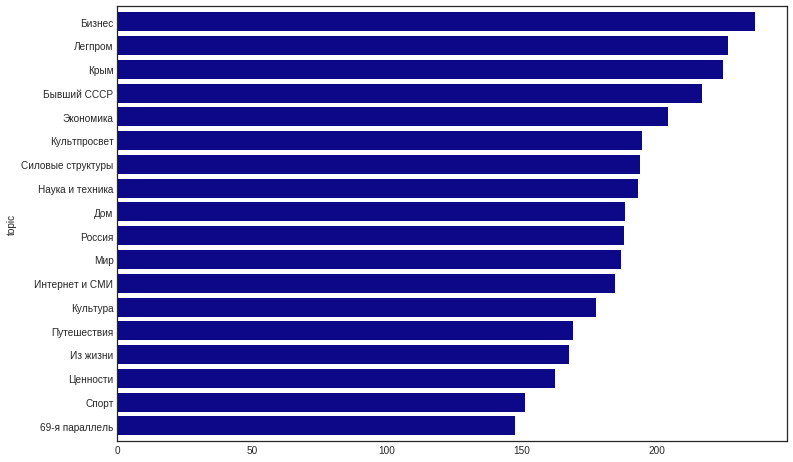

In [0]:
df_concat = pd.concat([df_small, y_small], axis=1)
df_concat.groupby(['topic'])['word_count_text'].\
mean().sort_values().plot(kind='barh', width=0.8, colormap='plasma')

Plot 'word_count_text' distribution for all topics. May check other statistics to discover insights

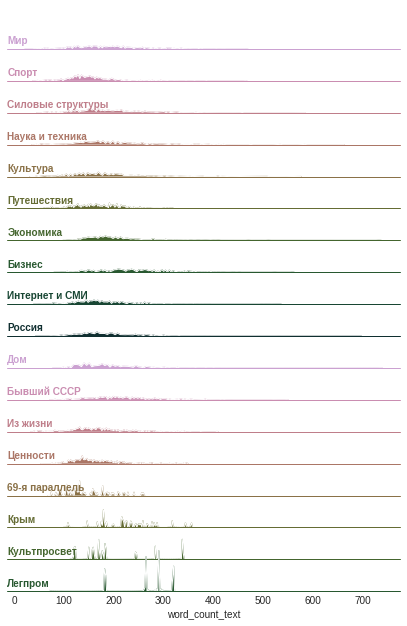

In [0]:
def ridge_plot(df, variable):
    pal = sns.cubehelix_palette(10, rot=-1.25, light=.7)
    g = sns.FacetGrid(df, row='topic', hue='topic', aspect=12, height=0.5, palette=pal)
    g.map(sns.kdeplot, variable, clip_on=False, shade=True, alpha=1, lw=1, bw=.9)
    g.map(sns.kdeplot, variable, clip_on=False, color='w', lw=1, bw=.9)
    g.map(plt.axhline, y=0, lw=1, clip_on=False)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight='bold', color=color,
                ha='left', va='center', transform=ax.transAxes)
    g.map(label, variable)
    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles('')
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    return g

ridge_plot(df_concat, 'word_count_text')

Zipf's Law

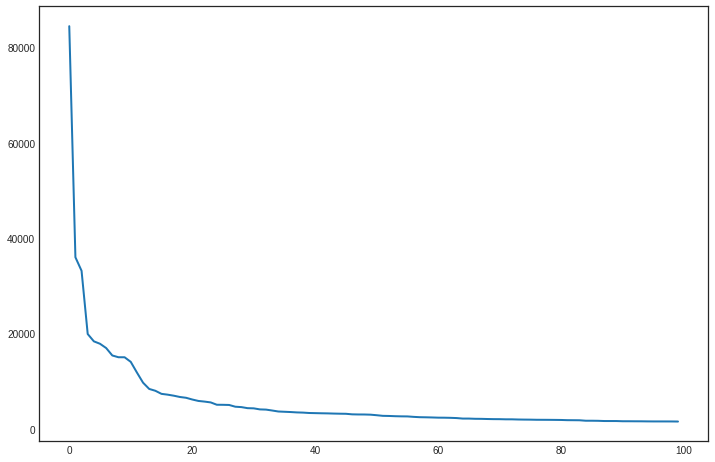

In [0]:
def zipf_law(df):
    """ Plot Zipf's emperical law"""    
    frequency = {}
    for text in df['text']:
        for word in text.split():
            count = frequency.get(word, 0)
            frequency[word] = count + 1
    plt.plot(sorted(frequency.values(), reverse=True)[:100])
zipf_law(df_small)

Plot histogram of characters 

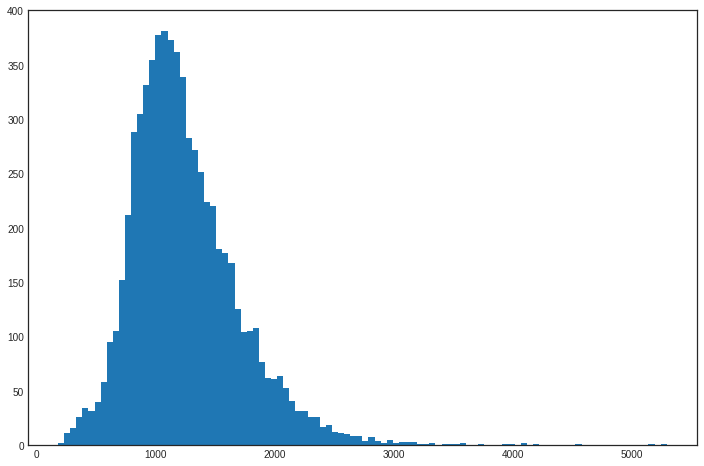

In [0]:
plt.hist(df_small['char_count_text'], bins=100)
plt.show()

# More preprocessing

In [0]:
from collections import defaultdict

frequency = defaultdict(int)
for text in df_small['text']:
    for word in text.split():
        frequency[word] += 1

## Label Encoder

Count and replace rare categories with tag 'rare' (not for target variable)

In [0]:
def value_counts_remove(df_train: pd.DataFrame, cols=List[str]):
    """ Remove rare categories """
    
    for col in cols:
        tmp = df_train[col].value_counts()[df_train[col].value_counts() < 20].index
        df_train.loc[df_train[col].isin(tmp), col] = 'rare'
    
value_counts_remove(df_small, ['section'])

In [0]:
# LabelEncoder
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in set(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

def label_encoder(df_train: pd.DataFrame, cols=List[str]):
    for col in cols:
        le = LabelEncoderExt()
        le.fit(df_train.loc[~df_train[col].isin([np.nan]), col].values)
        df_train.loc[~df_train[col].isin([np.nan]), col] = le.transform(df_train.loc[~df_train[col].isin([np.nan]), col])
        
label_encoder(df_small, ['section'])

In [0]:
# label encoder for target variable
le = LabelEncoder()
y_small = le.fit_transform(y_small)
y_small = pd.Series(y_small, name='topic')

## Continuous variables transformations
---
Only numeric features. 'Text' and 'title' columns are dropped

In [0]:
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, VarianceThreshold

Drop columns with 0 variation (all values are the same)


In [0]:
mask = (np.std(df_small, axis=0) == 0)
df_small.drop(mask.index[mask], axis=1, inplace=True)
print(f'{len(mask.index[mask])} have been dropped')

1 have been dropped


CV scores for different type of transformations for only numeric variables (excluding texts, titles)


In [0]:
numeric_transformators = [RobustScaler(), StandardScaler(), MaxAbsScaler()]
clfs = [RandomForestClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')]

def numeric_transformation(train, target, cols, clfs, transformers):
    """
    Apply different transformation for numeric columns (without texts, labels)
    with predefined classifiers and check validation scores
    """
    
    for clf in clfs:
        clf_name = str(clf).split('(')[0]
        print(f'For {clf_name}:')
        score_no_trans = np.round(cross_val_score(clf, train, target, cv=cv, scoring='f1_weighted', n_jobs=-1), 4)
        mean_no_trans = np.round(np.mean(score_no_trans), 4)
        std_no_trans = np.round(np.std(score_no_trans), 4)
        print(f'Without transformation the average is {mean_no_trans} with scores {score_no_trans} +/-{std_no_trans}')
        for scaler in transformers:
            classifier_pipeline = make_pipeline(scaler, clf)
            score = np.round(cross_val_score(classifier_pipeline, train, target, cv=cv, scoring='f1_weighted', n_jobs=-1), 4)
            mean = np.round(np.mean(score), 4)
            std = np.round(np.std(score), 4)
            scaler_name = str(scaler).split('(')[0]
            print(f'For {scaler_name} transformation the average is {mean} with scores {score} +/-{std}')
        print('\n')

cols_to_transform = df_small.drop(['text', 'title'], axis=1).columns
numeric_transformation(df_small.drop(['text', 'title'], axis=1), y_small, cols_to_transform, clfs, numeric_transformators)

For RandomForestClassifier:
Without transformation the average is 0.1003 with scores [0.1003 0.103  0.1031 0.0999 0.095 ] +/-0.0029
For RobustScaler transformation the average is 0.104 with scores [0.1014 0.1077 0.1154 0.0953 0.1   ] +/-0.007
For StandardScaler transformation the average is 0.1002 with scores [0.1015 0.0973 0.0957 0.095  0.1113] +/-0.006
For MaxAbsScaler transformation the average is 0.1012 with scores [0.0967 0.0902 0.1138 0.1101 0.0953] +/-0.0091


For LogisticRegression:
Without transformation the average is 0.0462 with scores [0.0533 0.0418 0.0516 0.0421 0.0421] +/-0.0051
For RobustScaler transformation the average is 0.0597 with scores [0.056  0.0507 0.0616 0.0668 0.0636] +/-0.0057
For StandardScaler transformation the average is 0.0597 with scores [0.056  0.0507 0.0616 0.0666 0.0636] +/-0.0057
For MaxAbsScaler transformation the average is 0.0487 with scores [0.054  0.0418 0.0512 0.0544 0.0421] +/-0.0056


For LinearDiscriminantAnalysis:
Without transformation th

In [0]:
#-----------------------------------------------------------------------#
# Drop zero variation columns
# Choose best transformation - fit_transform on train, transform on test
#-----------------------------------------------------------------------#

## Univariate feature selection

Use logistic regression and f-score for univariate feature selection


In [0]:
def f_value_classification(train, target, bot_threshold, n_splits):
    """
    Calculate validation scores for univariate feature selection with F-score
    """
    threshold = np.linspace(len(train.columns), bot_threshold, n_splits, dtype=int)
    for number in threshold:
        f_value_selector = SelectKBest(f_classif, number)
        train_selected = pd.DataFrame(f_value_selector.fit_transform(train, target))
        scores = np.round(cross_val_score(LogisticRegression(), train_selected, target, scoring=f1score, cv=cv, n_jobs=-1), 4)
        mean = np.round(np.mean(scores), 4)
        std = np.round(np.std(scores), 4)
        print(f'For threshold {number}: average is {mean}, std is {std}, scores are {scores}')

f_value_classification(df_small.drop(['text', 'title'], axis=1), y_small, 65, 20)

For threshold 84: average is 0.3674, std is 0.0068, scores are [0.3607 0.3691 0.366  0.3616 0.3796]
For threshold 83: average is 0.3693, std is 0.0078, scores are [0.3587 0.3675 0.3683 0.3689 0.3829]
For threshold 82: average is 0.369, std is 0.006, scores are [0.362  0.3658 0.3691 0.3682 0.3799]
For threshold 81: average is 0.3695, std is 0.007, scores are [0.3636 0.3685 0.3692 0.3634 0.3826]
For threshold 80: average is 0.3672, std is 0.0072, scores are [0.3588 0.3637 0.3652 0.368  0.3803]
For threshold 79: average is 0.3682, std is 0.0076, scores are [0.3606 0.3668 0.3724 0.3606 0.3806]
For threshold 78: average is 0.3658, std is 0.0062, scores are [0.36   0.3624 0.3675 0.3619 0.3771]
For threshold 77: average is 0.3651, std is 0.0051, scores are [0.3609 0.3646 0.3711 0.3583 0.3704]
For threshold 76: average is 0.3662, std is 0.0069, scores are [0.3559 0.3624 0.3756 0.3655 0.3717]
For threshold 75: average is 0.3649, std is 0.005, scores are [0.3594 0.3615 0.371  0.3616 0.3709]
For 

In [0]:
#-----------------------------------------------------------------------#
# Drop unneccessary columns (68 is the best)
#-----------------------------------------------------------------------#

## Rake

In [0]:
# Rake 

## N-grams

In [0]:
# Create N-grams

## Topic and text

In [0]:
# 9. Count matching between 'title' and 'text'

## ?

In [0]:
# Поиск разрывных коллокаций (после лематизации)
# Меры ассоциации биграм (T-SCORE or RawFreq, (Chi_square, PMI) via nltk.collocations)
# TextRank in GenSim

# LDA https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
# LDA https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

## Word Embedings
- word embedings + PCA

In [0]:
# Word embedings with 'FastText' or 'Word2Vec' + PCA

## TF-IDF
- do TFIDF with PCA, ICA, etc

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

Lets check top unigrams assciated with each category

In [0]:
# Calculate tfidf features
tfidf = TfidfVectorizer(max_df=0.5, min_df=0.01, max_features=5000)
features = tfidf.fit_transform(df_small['text']).toarray()

# Find top words asscociated with each topics category
def top_unigrams_for_target(target, number):
    """ Print top-number unigrams for each target category"""

    # we use LabelEncoder fitted earlier on target
    #(https://colab.research.google.com/drive/104oBcvB0MoIZtVxFUdaV08SFG97YrnfB#scrollTo=wEALXQjBWexu&line=4&uniqifier=1)
    category_to_id = dict(zip(le.classes_, range(len(le.classes_))))
    print(f'Most correlated unigrams:')
    for product, category_id in sorted(category_to_id.items()):
        features_chi2 = chi2(features, target == category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        print(f'#{product}: {unigrams[-5:]}')

top_unigrams_for_target(y_small, 5)

Most correlated unigrams:
#69-я параллель: ['морской', 'северный', 'округ', 'север', 'край']
#Бизнес: ['предприятие', 'завод', 'продукция', 'газ', 'компания']
#Бывший СССР: ['донбасс', 'порошенко', 'украинский', 'киев', 'украина']
#Дом: ['ставка', 'квадратный', 'недвижимость', 'жилье', 'квартира']
#Из жизни: ['животный', 'собака', 'daily', 'mail', 'животное']
#Интернет и СМИ: ['аккаунт', 'соцсеть', 'сеть', 'сервис', 'пользователь']
#Крым: ['полуостров', 'мост', 'крымский', 'крым', 'севастополь']
#Культпросвет: ['исторический', 'режиссер', 'выставка', 'музей', 'культура']
#Культура: ['музыкант', 'актер', 'режиссер', 'картина', 'фильм']
#Легпром: ['товар', 'изделие', 'производитель', 'легкий', 'промышленность']
#Мир: ['reuters', 'сирия', 'сша', 'иго', 'трамп']
#Наука и техника: ['исследование', 'планета', 'исследователь', 'космический', 'ученый']
#Путешествия: ['отдых', 'авиакомпания', 'рейс', 'путешественник', 'турист']
#Россия: ['кремль', 'мчс', 'область', 'госдума', 'песков']
#Силовые

In [0]:
# Average: 0.7357
def tf_idf_cv(df, target, clf): 
    """ CV scores for tfidf transformation"""
    
    scores = []
    for train_index, test_index in cv.split(df, target): #cv defined in cv-block
        x_train = df.loc[train_index, :].copy().reset_index(drop=True)
        x_test = df.loc[test_index, :].copy().reset_index(drop=True)
        y_train = target.loc[train_index].copy().reset_index(drop=True)
        y_test = target.loc[test_index].copy().reset_index(drop=True)
        
        # transform text
        tfidf = TfidfVectorizer(max_df=0.5, min_df=0.01, max_features=5000)
        text_train = tfidf.fit_transform(x_train['text']).toarray()
        text_train = pd.DataFrame(text_train)
        x_train = pd.concat([x_train, text_train], axis=1, ignore_index=False)
        text_test = tfidf.transform(x_test['text']).toarray()
        text_test = pd.DataFrame(text_test)
        x_test = pd.concat([x_test, text_test], axis=1)
        x_train.drop(['text'], axis=1, inplace=True)
        x_test.drop(['text'], axis=1, inplace=True)

        # Transform title
        tfidf = TfidfVectorizer(max_df=0.5, min_df=0.001, max_features=5000)
        title_train = tfidf.fit_transform(x_train['title']).toarray()
        title_train = pd.DataFrame(title_train)
        x_train = pd.concat([x_train, title_train], axis=1, ignore_index=False)
        title_test = tfidf.transform(x_test['title']).toarray()
        title_test = pd.DataFrame(title_test)
        x_test = pd.concat([x_test, title_test], axis=1)
        x_train.drop(['title'], axis=1, inplace=True)
        x_test.drop(['title'], axis=1, inplace=True)
        #return x_train, x_test

        # Fit/predict
        clf.fit(x_train, y_train)
        score = round(f1_score(clf.predict(x_test), y_test, average='weighted'), 4)
        scores.append(score)

    mean = round(np.mean(scores), 4)
    std = round(np.std(scores), 4)
    print(f'Average: {mean}, std: +/-{std}, scores: {scores}')
        
tf_idf_cv(df_small, y_small, LogisticRegression())

Average: 0.7357, std: +/-0.008, scores: [0.7386, 0.7495, 0.7309, 0.7336, 0.7259]


After we conduct tfidf lets check how does score imporove with and without text statistics we calculated above

In [0]:
# Average: 0.7473
def tf_idf_cv_no_stats(df, target, clf): 
    """ CV scores for tfidf transformation without stats features"""
    
    scores = []
    cols_to_drop = df.drop(['title', 'text'], axis=1).columns
    for train_index, test_index in cv.split(df, target): #cv defined in cv-block
        x_train = df.loc[train_index, :].copy().reset_index(drop=True)
        x_test = df.loc[test_index, :].copy().reset_index(drop=True)
        y_train = target.loc[train_index].copy().reset_index(drop=True)
        y_test = target.loc[test_index].copy().reset_index(drop=True)
        x_train.drop(cols_to_drop, axis=1, inplace=True)
        x_test.drop(cols_to_drop, axis=1, inplace=True)

        # transform text
        tfidf = TfidfVectorizer(max_df=0.5, min_df=0.01, max_features=5000)
        text_train = tfidf.fit_transform(x_train['text']).toarray()
        text_train = pd.DataFrame(text_train)
        x_train = pd.concat([x_train, text_train], axis=1, ignore_index=False)
        text_test = tfidf.transform(x_test['text']).toarray()
        text_test = pd.DataFrame(text_test)
        x_test = pd.concat([x_test, text_test], axis=1)
        x_train.drop(['text'], axis=1, inplace=True)
        x_test.drop(['text'], axis=1, inplace=True)

        # Transform title
        tfidf = TfidfVectorizer(max_df=0.5, min_df=0.001, max_features=5000)
        title_train = tfidf.fit_transform(x_train['title']).toarray()
        title_train = pd.DataFrame(title_train)
        x_train = pd.concat([x_train, title_train], axis=1, ignore_index=False)
        title_test = tfidf.transform(x_test['title']).toarray()
        title_test = pd.DataFrame(title_test)
        x_test = pd.concat([x_test, title_test], axis=1)
        x_train.drop(['title'], axis=1, inplace=True)
        x_test.drop(['title'], axis=1, inplace=True)
        #return x_train, x_test

        # Fit/predict
        clf.fit(x_train, y_train)
        score = round(f1_score(clf.predict(x_test), y_test, average='weighted'), 4)
        scores.append(score)

    mean = round(np.mean(scores), 4)
    std = round(np.std(scores), 4)
    print(f'Average: {mean}, std: +/-{std}, scores: {scores}')
        
tf_idf_cv_no_stats(df_small, y_small, LogisticRegression())

Average: 0.7473, std: +/-0.0092, scores: [0.7493, 0.7611, 0.7366, 0.7516, 0.7377]


In [0]:
corpus = nltk.sent_tokenize(df_small['text'])

TypeError: ignored

## Topic models as features

In [0]:
# Latent Dirichlet Allocation
# BigARTM (http://www.machinelearning.ru/wiki/images/6/6d/BigARTM-short-intro.pdf)

# Prepare set

## Chunking

# Models

## Naive Bayes

## Logisitc Regression

## SVM

## RF

## CatBoost/LGBM

## CNN

## RNN

# Sources

In [0]:
# 1. https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/